# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline 

from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
## Load the data into a DataFrame
csv_filepath = '/Users/kristensu/downloads/Iowa_Liquor_sales_sample_10pct.csv'
iowa = pd.read_csv(csv_filepath)

In [3]:
iowa.head(3)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34


In [16]:
iowa.dtypes

Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object

In [ ]:
print iowa.columns
print iowa.shape

# Clean Data

### Drop duplicate (unnecessary) columns

In [4]:
# Drop cols that contain same info as another col
iowa.drop(['County Number', 'Item Number', 'Volume Sold (Gallons)'], axis=1, inplace=True)

In [22]:
# Made a separate df for category to category name mapping for future reference
category_df = pd.pivot_table(iowa, index=['Category', 'Category Name'], values=['Bottles Sold'])
category_df.drop('Bottles Sold', axis=1, inplace=True)
category_df.head(2)

,
Category,Category Name
1011100.0,BLENDED WHISKIES
1011200.0,STRAIGHT BOURBON WHISKIES


### Clean column names

In [23]:
# Clean column name 1: Rename columns
iowa.rename(columns={'Store Number':'Store', 'Bottle Volume (ml)':'Bottle Volume', 'Sale (Dollars)':'Sales', \
               'Volume Sold (Liters)':'Volume Sold'}, inplace=True)

# Clean column names 2: Change all column names to lowercase letters
iowa.rename(columns=lambda x: x.lower(), inplace=True)

# Clean column names 3: Replace ' ' with '_'
iowa.rename(columns=lambda x: x.replace(" ","_"), inplace=True)


### Clean values in columns with currency and date

In [24]:
# Convert columns with dollar amounts from object to numeric float
currency = ['sales', 'state_bottle_cost', 'state_bottle_retail']
iowa[currency] = iowa[currency].apply(lambda x: x.str.replace('$',''))
iowa[currency] = iowa[currency].apply(lambda x: x.str.replace(',',''))
iowa[currency] = iowa[currency].apply(lambda x: pd.to_numeric(x))

In [29]:
# Convert date from object to datetime
iowa['date'] = pd.to_datetime(iowa['date'])
%timeit 

In [ ]:
# Convert zip code to int
print iowa['zip_code'].nunique()
print iowa['zip_code'].unique()
# One problematic value: 712-2

In [31]:
# Drop problematic zip code and convert rest to int
iowa['zip_code'] = pd.to_numeric(iowa["zip_code"], errors='coerce')
iowa.fillna(np.nan)
iowa['zip_code'].dropna().astype(int)
iowa['zip_code'].head(2)

0    50674.0
1    52807.0
Name: zip_code, dtype: float64

In [49]:
iowa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270323 entries, 0 to 270954
Data columns (total 21 columns):
date                     270323 non-null datetime64[ns]
store                    270323 non-null int64
city                     270323 non-null object
zip_code                 270107 non-null float64
county_number            269258 non-null float64
county                   270323 non-null object
category                 270323 non-null float64
category_name            270323 non-null object
vendor_number            270323 non-null int64
item_number              270323 non-null int64
item_description         270323 non-null object
bottle_volume            270323 non-null int64
state_bottle_cost        270323 non-null float64
state_bottle_retail      270323 non-null float64
bottles_sold             270323 non-null int64
sales                    270323 non-null float64
volume_sold              270323 non-null float64
volume_sold_(gallons)    270323 non-null float64
year          

### Convert dtype object to str

In [51]:
iowa['city'] = iowa['city'].astype(str)
iowa['county'] = iowa['county'].astype(str)
iowa['category_name'] = iowa['category_name'].astype(str)
iowa['item_description'] = iowa['item_description'].astype(str)

### Extract dates into year, quarter and month

In [32]:
def extract_month(x):
    month = str('{:02d}'.format(x.month)) + "-" + str((x.year))
    return month
def extract_quarter(x):
    quarter = "Q" + str(x.quarter) + "-" + str(x.year)
    return quarter

iowa["year"] = iowa["date"].dt.year
iowa["quarter"] = iowa["date"].apply(extract_quarter)
iowa["month"] = iowa["date"].apply(extract_month)

### Check for and replace NaNs

In [ ]:
iowa.isnull().sum()
#Will leave zip_code NaNs as I filled problematic zip code with np.nan above

### Remove Duplicate County Names & Fill in Missing Counties

In [34]:
# Match missing County with City
df_county = pd.pivot_table(iowa, index=['city', 'county'], values=['sales'], aggfunc=sum)
df_county.drop('sales', axis=1, inplace=True)
df_county.reset_index(inplace=True)
df_county.head()

,city,county
0,ACKLEY,Hardin
1,ACKLEY,Webster
2,ADAIR,Adair
3,ADEL,Dallas
4,AFTON,Union


In [35]:
print df_county['city'].duplicated().sum()
a = df_county[df_county['city'].duplicated() == True].index.tolist()
df_county['city'].loc[a]

11


1               ACKLEY
33          BETTENDORF
66               CLIVE
74             CORNING
135         FORT DODGE
260             NEWTON
264      NORTH LIBERTY
277          OSKALOOSA
289              PERRY
337       STATE CENTER
380    WEST DES MOINES
Name: city, dtype: object

In [36]:
# Did not use drop_duplicates() because I did not want to automatically drop the second duplicate
# So I checked the counties of duplicate cities and dropped incorrect city-county mappings
# It also turns out some towns (Ackley, Clive, and West Des Moines are located in multiple counties)
# Remove from iowa dataframe: index [32, 74, 134, 260, 263, 276, 288, 336]

b = [i+1 for i in a]
c = [i-1 for i in a]
d = a + b + c
e = sorted(d)

df_county.loc[e, :]
county_dict = {'bettendorf':'scott', 'corning':'adams', 'fort dodge': 'webster','newton':'jasper', \
               'north libery':'johnson', 'OSKALOOSA': 'mahaska', 'PERRY':'dallas', 'STATE CENTER': 'marshall'}

In [ ]:
# Remove from iowa dataframe: index [32, 74, 134, 260, 263, 276, 288, 336]
df_county.drop([32, 74, 134, 260, 263, 276, 288, 336], inplace=True)

# Rename Ackley, Clive, and West Des Moines to account for parts of town in different counties
df_county.set_value([1,66,380], 'city', ['ACKLEY_WEBSTER', 'CLIVE_POLK', 'WEST_DES_MOINES_POLK'])

In [39]:
# Merge df_county into original iowa df
# Note: Original "county" renamed "county_x" and new "county_y" col created
iowa = pd.merge(iowa,df_county, on = 'city', how = 'left')
iowa.head(3)

,date,store,city,zip_code,county_number,county_x,category,category_name,vendor_number,item_number,...,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold,volume_sold_(gallons),year,quarter,month,county_y
0,2015-11-04,3717,SUMNER,50674.0,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,4.50,6.75,12,81.00,9.0,2.38,2015,Q4-2015,11-2015,Bremer
1,2016-03-02,2614,DAVENPORT,52807.0,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,...,13.75,20.63,2,41.26,1.5,0.40,2016,Q1-2016,03-2016,Scott
2,2016-02-11,2106,CEDAR FALLS,50613.0,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,...,12.59,18.89,24,453.36,24.0,6.34,2016,Q1-2016,02-2016,Black Hawk


In [ ]:
# Fill missing county names in "county_x" with county names from "county_y"
iowa['county_x'].fillna(iowa['county_y'], inplace=True)
iowa.isnull().sum()

In [41]:
# Check for remaining missing counties
iowa[iowa["county_x"].isnull()]['city'].unique()

array(['TABOR', 'SEYMOUR', 'RUNNELLS'], dtype=object)

In [43]:
# Fill in missing counties by mapping to city
def county_name(city):
    if city == "TABOR":
        return "Fremont"
    elif city == "SEYMOUR":
        return "Wayne"
    elif city == "RUNNELLS":
        return "Polk"
    else:
        pass

iowa['county_y'] = iowa['city'].apply(county_name)
iowa['county_x'].fillna(iowa['county_y'], inplace=True)

In [ ]:
iowa.isnull().sum()

### Drop Missing Values in "category_name"

In [44]:
# Find duplicates in category name
df_category_name = pd.pivot_table(iowa,index = ['item_description','category_name'], \
                                  values = ['sales'], aggfunc = sum)
df_category_name.reset_index(inplace = True)
df_category_name.drop('sales', axis=1, inplace=True)
df_category_name.duplicated().sum()
# No duplicates

0

In [45]:
# Drop rows with NaN in "category_name" col as it is only 0.233% of total 
# Did not have the time (as I did for counties above) to go through the 632 NaN rows
null_cat_percent = (iowa['category_name'].isnull().sum())/ \
                    float(len(iowa['category_name']))*100
print str(round(null_cat_percent, 3)) + '% of total rows ' + 'is null'
print 'These 632 rows will be dropped from analysis'

iowa.dropna(subset=[['category_name']], inplace=True)
iowa[['category_name']].head(3)

0.233% of total rows is null
These 632 rows will be dropped from analysis


,category_name
0,APRICOT BRANDIES
1,BLENDED WHISKIES
2,STRAIGHT BOURBON WHISKIES


In [ ]:
iowa.isnull().sum()

In [46]:
# Drop county_y column and rename county_x as county
iowa.drop('county_y', axis=1, inplace=True)
iowa.rename(columns={'county_x':'county'}, inplace=True)

### Create new columns with metrics

In [47]:
# Just checking to make that that the 'sales' columns represents total revenue
iowa['sales_check'] = iowa['state_bottle_retail'] * iowa['bottles_sold']
print sum(iowa['sales_check']-iowa['sales'])
iowa.drop('sales_check', axis=1, inplace=True)

2.71302980082e-11


In [85]:
# New metrics added to iowa
iowa['profit'] = (iowa['state_bottle_retail'] - iowa['state_bottle_cost']) * iowa['bottles_sold']
iowa['rev_per_ml'] = iowa['sales'] / iowa['volume_sold']
iowa['price_per_ml'] = iowa['state_bottle_retail'] / iowa['volume_sold']
iowa['margin_percent'] = iowa['profit'] / iowa['sales']
iowa['profit_per_ml'] = iowa['profit'] / iowa['volume_sold']
iowa['profit_%_per_ml'] = iowa['profit_per_ml'] / iowa['rev_per_ml']

In [105]:
print 'Iowa is a "control state", meaning the state has direct control over the wholesale alcohol \
market. The state dictates retail prices at a set margin of 33.3%.'
print 'See Iowa Alcoholic Beverages Division for more info.'
iowa.iloc[:3,11:28]

Iowa is a "control state", meaning the state has direct control over the wholesale alcohol market. The state dictates retail prices at a set margin of 33.3%.
See Iowa Alcoholic Beverages Division for more info.


,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold,year,quarter,month,profit,price_per_ml,rev_per_ml,profit_per_ml
0,750,4.50,6.75,12,81.00,9.0,2015,Q4-2015,11-2015,27.00,0.750000,9.000000,3.000000
1,750,13.75,20.63,2,41.26,1.5,2016,Q1-2016,03-2016,13.76,13.753333,27.506667,9.173333
2,1000,12.59,18.89,24,453.36,24.0,2016,Q1-2016,02-2016,151.20,0.787083,18.890000,6.300000


In [128]:
# Drop margin % columns (they are constant and will not affect model)
iowa.drop(['margin_percent', 'profit_%_per_ml'], inplace=True,axis=1)

# Add $margin per bottle as this is not a constant measure
iowa['profit_per_bottle'] = iowa['state_bottle_retail'] - iowa['state_bottle_cost']
iowa.iloc[:2,11:28]

,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold,year,quarter,month,profit,price_per_ml,rev_per_ml,profit_per_ml,profit_per_bottle
0,750,4.50,6.75,12,81.00,9.0,2015,Q4-2015,11-2015,27.00,0.750000,9.000000,3.000000,2.25
1,750,13.75,20.63,2,41.26,1.5,2016,Q1-2016,03-2016,13.76,13.753333,27.506667,9.173333,6.88


### Drop stores that were only partially open in 2015

In [92]:
# Check for stores that were not open for the full year or closed during the year
dates_open = iowa.groupby(["store"])["date"].agg([min, max])
dates_open.reset_index(inplace=True)
dates_open.tail(3)

,store,min,max
1397,9013,2015-06-04,2016-03-09
1398,9018,2015-10-27,2015-10-27
1399,9023,2016-03-08,2016-03-08


In [93]:
def open_date(x):
    if x > pd.to_datetime('2015-03-31'):
        return 1
    else:
        return 0
    
def close_date(x):
    if x <= pd.to_datetime('2015-12-31'):
        return 1
    else:
        return 0
    
dates_open["closed"] = dates_open["max"].apply(close_date)
dates_open["opened"] = dates_open["min"].apply(open_date)
dates_open["partial_year"] = dates_open["closed"] + dates_open["opened"]

In [94]:
dates_open.tail(3)

,store,min,max,closed,opened,partial_year
1397,9013,2015-06-04,2016-03-09,0,1,1
1398,9018,2015-10-27,2015-10-27,1,1,2
1399,9023,2016-03-08,2016-03-08,0,1,1


In [100]:
# List of 217 stores not open full year in 2015
partial_stores = list(dates_open[dates_open["partial_year"]!=0]["store"].values)
print 'Number of stores not open for full year 2015: ' + str(len(partial_stores))

open_stores = list(dates_open[dates_open['partial_year'] == 0]['store'].values)
print 'Total stores: '+ str(len(partial_stores) + len(open_stores))
print 'Total stores open all of 2015: ' + str(len(open_stores))


Number of stores not open for full year 2015: 217
Total stores: 1400
Total stores open all of 2015: 1183


In [101]:
# Amount of revenue generated by stores only partially open in 2015
partial_rev = sum(iowa[iowa['store'].isin(partial_stores)]['sales']) / sum(iowa['sales']) 
print 'Only ' + str(round(partial_rev*100,2)) + '% of sales from stores partially open in 2015'
print 'Sales from these 217 stores will be dropped from analysis'

Only 3.73% of sales from stores partially open in 2015
Sales from these 217 stores will be dropped from analysis


## Create a new df with only stores open for full year 2015

In [288]:
# Create new df consisting only of stores open for full year 2015
idf = iowa[iowa['store'].isin(open_stores)]

## Create a new df summarizing 2015 data only

In [290]:
# Create a df summarizing total sales and revenues in 2015 at store-level
sum_metrics = ['sales', 'profit']
iowa_sum_2015 = idf[idf['year'] == 2015].groupby(['store'])[sum_metrics].agg(np.sum)
iowa_sum_2015.columns = ['2015_total_revenue','2015_profit']
iowa_sum_2015.reset_index(inplace=True)
print len(iowa_sum_2015)
iowa_sum_2015.describe(include='all')

1183


,store,2015_total_revenue,2015_profit
count,1183.000000,1183.000000,1183.000000
mean,4165.122570,23218.195748,7764.436534
std,812.526287,54099.137842,18064.287528
min,2106.000000,450.010000,150.090000
25%,3805.500000,3897.355000,1303.865000
50%,4376.000000,8407.240000,2805.030000
75%,4740.500000,21844.450000,7338.015000
max,9010.000000,997924.420000,332863.870000


In [292]:
# Create a df summarizing mean metrics for 2015 at store-level
mean_metrics = ['sales', 'profit', 'price_per_ml', 'profit_per_ml', 'profit_per_bottle']
iowa_mean_2015 = idf[idf['year'] == 2015].groupby(['store'])[mean_metrics].agg(np.mean)
iowa_mean_2015.columns = ['2015_avg_rev','2015_avg_profit','2015_avg_price_per_ml', \
                         '2015_avg_profit_per_ml', '2015_avg_profit_per_bottle']
iowa_mean_2015.reset_index(inplace=True)
print len(iowa_mean_2015)
iowa_mean_2015.describe(include='all')

1183


,store,2015_avg_rev,2015_avg_profit,2015_avg_price_per_ml,2015_avg_profit_per_ml,2015_avg_profit_per_bottle
count,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000
mean,4165.122570,123.926313,41.458373,4.714215,5.685850,4.564185
std,812.526287,117.577581,39.327318,2.914395,1.249910,0.988594
min,2106.000000,24.757826,8.268261,0.543021,3.173605,1.488667
25%,3805.500000,76.632554,25.596544,2.198975,4.945446,3.935385
50%,4376.000000,106.078333,35.546951,4.280716,5.537004,4.540980
75%,4740.500000,143.660356,48.125233,6.397115,6.228304,5.098574
max,9010.000000,2061.811833,691.704000,19.266372,27.428178,11.653750


In [297]:
# Create a df showing all days with sales for each store

idf_open = idf.loc[:,['store', 'date', 'year', 'quarter']]
idf_open.drop_duplicates(['store', 'date'], inplace=True)
idf.sort_values('store').head()

days_open_15 = idf_open[idf_open['year'] == 2015].groupby(['store'])[['date']].agg(len)
days_open_15.reset_index(inplace=True)
days_open_15.columns = ['store', 'days_open_15']
days_open_15['days_open_15'] = days_open_15['days_open_15'].astype(int)

In [299]:
# Create daily metrics (rev_per_day and profit_per_day) with days_open data 
iowa_sum_2015['2015_rev_per_day'] = iowa_sum_2015['2015_total_revenue'] / days_open_15['days_open_15']
iowa_sum_2015['2015_profit_per_day'] = iowa_sum_2015['2015_profit'] / days_open_15['days_open_15']
iowa_sum_2015.head()

,store,2015_total_revenue,2015_profit,2015_rev_per_day,2015_profit_per_day
0,2106,146038.70,48742.20,2808.436538,937.350000
1,2113,9310.22,3109.04,198.089787,66.149787
2,2130,111583.91,37229.32,2145.844423,715.948462
3,2152,7721.08,2587.53,157.573061,52.806735
4,2178,24324.18,8165.70,476.944706,160.111765


In [300]:
# Create df of categorical variables only 
idf_category = idf.loc[:,['store', 'city', 'county', 'zip_code']].drop_duplicates()

# Merge (left join) iowa_sum, iowa_mean and days_open_15 to create df of all stores for 2015 data 
idf_2015 = pd.merge(idf_category, days_open_15, how='left', on='store'). \
merge(iowa_sum_2015, how='left', on='store').merge(iowa_mean_2015, how='left', on='store')
print len(idf_2015)
print 'Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.'
idf_2015.head(3)

1185
Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.


,store,city,county,zip_code,days_open_15,2015_total_revenue,2015_profit,2015_rev_per_day,2015_profit_per_day,2015_avg_rev,2015_avg_profit,2015_avg_price_per_ml,2015_avg_profit_per_ml,2015_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,50,9022.86,3011.02,180.457200,60.220400,34.438397,11.492443,10.623053,5.389800,5.103779
1,2614,DAVENPORT,Scott,52807.0,52,142675.29,47695.76,2743.755577,917.226154,138.385344,46.261649,7.146836,6.427207,5.232396
2,2106,CEDAR FALLS,Black Hawk,50613.0,52,146038.70,48742.20,2808.436538,937.350000,277.640114,92.665779,2.790379,5.957151,5.160951


## Create a new df summarzing Q1-2015 data only

In [309]:
# Create a df summarizing total sales and revenues in 2015 at store-level
sum_metrics = ['sales', 'profit']
iowa_sum_2015Q1 = idf[idf['quarter'] == 'Q1-2015'].groupby(['store'])[sum_metrics].agg(np.sum)
iowa_sum_2015Q1.columns = ['Q1-15_total_revenue','Q1-15_profit']
iowa_sum_2015Q1.reset_index(inplace=True)
print len(iowa_sum_2015Q1)

# Create a df summarizing mean metrics
mean_metrics = ['sales', 'profit', 'price_per_ml', 'profit_per_ml', 'profit_per_bottle']
iowa_mean_2015Q1 = idf[idf['quarter'] == 'Q1-2015'].groupby(['store'])[mean_metrics].agg(np.mean)
iowa_mean_2015Q1.columns = ['Q1-15_avg_rev','Q1-15_avg_profit','Q1-15_avg_price_per_ml', \
                         'Q1-15_avg_profit_per_ml', 'Q1-15_avg_profit_per_bottle']
iowa_mean_2015Q1.reset_index(inplace=True)
print len(iowa_mean_2015Q1)

# Create days_open df for Q1-2015
days_open_15Q1 = idf_open[idf_open['quarter'] == 'Q1-2015'].groupby(['store'])[['date']].agg(len)
days_open_15Q1.reset_index(inplace=True)
days_open_15Q1.columns = ['store', 'days_open_15Q1']
days_open_15Q1['days_open_15Q1'] = days_open_15Q1['days_open_15Q1'].astype(int)

1183
1183


In [311]:
# Create daily metrics (rev_per_day and profit_per_day) with days_open data 
iowa_sum_2015Q1['rev_per_day'] = iowa_sum_2015Q1['Q1-15_total_revenue'] / days_open_15Q1['days_open_15Q1']
iowa_sum_2015Q1['profit_per_day'] = iowa_sum_2015Q1['Q1-15_profit'] / days_open_15Q1['days_open_15Q1']
iowa_sum_2015Q1.head()

,store,Q1-15_total_revenue,Q1-15_profit,rev_per_day,profit_per_day
0,2106,39287.29,13108.37,3273.940833,1092.364167
1,2113,2833.25,944.72,257.568182,85.883636
2,2130,24272.57,8108.68,2022.714167,675.723333
3,2152,2003.46,668.60,166.955000,55.716667
4,2178,5856.41,1961.28,488.034167,163.440000


In [313]:
# Merge (left join) iowa_sum, iowa_mean and days_open_15 to create df of all stores for 2015 data 
idf_2015Q1 = pd.merge(idf_category, days_open_15Q1, how='left', on='store')
idf_2015Q1 = pd.merge(idf_2015Q1,iowa_sum_2015Q1, how='left', on='store'). \
merge(iowa_mean_2015Q1, how='left', on='store')

print len(idf_2015Q1)
print 'Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.'
idf_2015Q1.head(3)

1185
Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.


,store,city,county,zip_code,days_open_15Q1,Q1-15_total_revenue,Q1-15_profit,rev_per_day,profit_per_day,Q1-15_avg_rev,Q1-15_avg_profit,Q1-15_avg_price_per_ml,Q1-15_avg_profit_per_ml,Q1-15_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,11,1583.13,527.81,143.920909,47.982727,35.980227,11.995682,11.149558,5.540246,4.902955
1,2614,DAVENPORT,Scott,52807.0,12,32260.12,10821.25,2688.343333,901.770833,135.546723,45.467437,5.584630,5.687667,4.805462
2,2106,CEDAR FALLS,Black Hawk,50613.0,12,39287.29,13108.37,3273.940833,1092.364167,304.552636,101.615271,3.432935,5.959059,5.033721


1185
Note: discrepancy between len(idf) and len(idf_2015) result of 2 stores each counted twice. No time to remove.


,store,city,county,zip_code,days_open,Q1-15_total_revenue,Q1-15_profit,rev_per_day,profit_per_day,Q1-15_avg_rev,Q1-15_avg_profit,Q1-15_avg_price_per_ml,Q1-15_avg_profit_per_ml,Q1-15_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,11,1583.13,527.81,143.920909,47.982727,35.980227,11.995682,11.149558,5.540246,4.902955
1,2614,DAVENPORT,Scott,52807.0,12,32260.12,10821.25,2688.343333,901.770833,135.546723,45.467437,5.584630,5.687667,4.805462
2,2106,CEDAR FALLS,Black Hawk,50613.0,12,39287.29,13108.37,3273.940833,1092.364167,304.552636,101.615271,3.432935,5.959059,5.033721


## Create a new df summarzing Q1-2016 data only

In [256]:
# Create a df summarizing total sales and revenues in 2016 at store-level
sum_metrics = ['sales', 'profit']
iowa_sum_2016Q1 = idf[idf['quarter'] == 'Q1-2016'].groupby(['store'])[sum_metrics].agg(np.sum)
iowa_sum_2016Q1.columns = ['Q1-16_total_revenue','Q1-16_profit']
iowa_sum_2016Q1.reset_index(inplace=True)
print len(iowa_sum_2016Q1)

# Create a df summarizing mean metrics
mean_metrics = ['sales', 'profit', 'price_per_ml', 'profit_per_ml', 'profit_per_bottle']
iowa_mean_2016Q1 = idf[idf['quarter'] == 'Q1-2016'].groupby(['store'])[mean_metrics].agg(np.mean)
iowa_mean_2016Q1.columns = ['Q1-16_avg_rev','Q1-16_avg_profit','Q1-16_avg_price_per_ml', \
                         'Q1-16_avg_profit_per_ml', 'Q1-16_avg_profit_per_bottle']
iowa_mean_2016Q1.reset_index(inplace=True)
print len(iowa_mean_2016Q1)

# Create days_open df for Q1-2016
days_open_16Q1 = idf_open[idf_open['quarter'] == 'Q1-2016'].groupby(['store'])[['date']].agg(len)
days_open_16Q1.reset_index(inplace=True)
days_open_16Q1.columns = ['store', 'days_open']
days_open_16Q1['days_open'] = days_open_15Q1['days_open'].astype(int)

1183
1183


In [260]:
iowa_sum_2016Q1.head(3)

,store,Q1-16_total_revenue,Q1-16_profit
0,2106,30478.75,10174.68
1,2113,2065.90,693.49
2,2130,27856.11,9288.29


In [262]:
# Create daily metrics (rev_per_day and profit_per_day) with days_open data 
iowa_sum_2016Q1['rev_per_day'] = iowa_sum_2016Q1['Q1-16_total_revenue'] / days_open_16Q1['days_open']
iowa_sum_2016Q1['profit_per_day'] = iowa_sum_2016Q1['Q1-16_profit'] / days_open_16Q1['days_open']

# Merge (left join) iowa_sum, iowa_mean and days_open_15 to create df of all stores for 2016 data 
idf_2016Q1 = pd.merge(idf_category, days_open_16Q1, how='left', on='store')
idf_2016Q1 = pd.merge(idf_2016Q1,iowa_sum_2016Q1, how='left', on='store'). \
merge(iowa_mean_2016Q1, how='left', on='store')

idf_2016Q1.head(3)
print len(idf_2016Q1)
print 'Note: discrepancy between len(idf) and len(idf_2016) result of 2 stores each counted twice. No time to remove.'
idf_2016Q1.head(3)

1185
Note: discrepancy between len(idf) and len(idf_2016) result of 2 stores each counted twice. No time to remove.


,store,city,county,zip_code,days_open,Q1-16_total_revenue,Q1-16_profit,rev_per_day,profit_per_day,Q1-16_avg_rev,Q1-16_avg_profit,Q1-16_avg_price_per_ml,Q1-16_avg_profit_per_ml,Q1-16_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,11,2510.46,837.57,228.223636,76.142727,34.867500,11.632917,10.805656,5.511753,5.455972
1,2614,DAVENPORT,Scott,52807.0,12,36360.48,12131.12,3030.040000,1010.926667,133.188571,44.436337,7.705376,6.472363,5.056520
2,2106,CEDAR FALLS,Black Hawk,50613.0,12,30478.75,10174.68,2539.895833,847.890000,241.894841,80.751429,3.686858,5.997147,5.196508


In [272]:
# Make sure all three new dfs are shame shape
print idf_2015.shape
print idf_2015Q1.shape
print idf_2016Q1.shape

(1185, 14)
(1185, 14)
(1185, 14)


In [273]:
###################################################
a1 = idf_2015.copy()
a2 = idf_2015Q1.copy()
a3 = idf_2016Q1.copy()

## Merge 2015, Q1-2015 and Q2-2015 dfs

In [275]:
stores_df = idf_2015.merge(idf_2015Q1, on=['store', 'county', 'city', 'zip_code'], how ='left')\
.merge(idf_2016Q1, on= ['store', 'county', 'city', 'zip_code'], how ="left")

In [284]:
print stores_df.shape
print pd.DataFrame(stores_df.columns)
stores_df.head(3)

(1185, 34)
                              0
0                         store
1                          city
2                        county
3                      zip_code
4                  days_open_15
5            2015_total_revenue
6                   2015_profit
7                 rev_per_day_x
8              profit_per_day_x
9                  2015_avg_rev
10              2015_avg_profit
11        2015_avg_price_per_ml
12       2015_avg_profit_per_ml
13   2015_avg_profit_per_bottle
14                  days_open_x
15          Q1-15_total_revenue
16                 Q1-15_profit
17                rev_per_day_y
18             profit_per_day_y
19                Q1-15_avg_rev
20             Q1-15_avg_profit
21       Q1-15_avg_price_per_ml
22      Q1-15_avg_profit_per_ml
23  Q1-15_avg_profit_per_bottle
24                  days_open_y
25          Q1-16_total_revenue
26                 Q1-16_profit
27                  rev_per_day
28               profit_per_day
29                Q1-16_avg_r

,store,city,county,zip_code,days_open_15,2015_total_revenue,2015_profit,rev_per_day_x,profit_per_day_x,2015_avg_rev,...,days_open_y,Q1-16_total_revenue,Q1-16_profit,rev_per_day,profit_per_day,Q1-16_avg_rev,Q1-16_avg_profit,Q1-16_avg_price_per_ml,Q1-16_avg_profit_per_ml,Q1-16_avg_profit_per_bottle
0,3717,SUMNER,Bremer,50674.0,50,9022.86,3011.02,180.457200,60.220400,34.438397,...,11,2510.46,837.57,228.223636,76.142727,34.867500,11.632917,10.805656,5.511753,5.455972
1,2614,DAVENPORT,Scott,52807.0,52,142675.29,47695.76,2743.755577,917.226154,138.385344,...,12,36360.48,12131.12,3030.040000,1010.926667,133.188571,44.436337,7.705376,6.472363,5.056520
2,2106,CEDAR FALLS,Black Hawk,50613.0,52,146038.70,48742.20,2808.436538,937.350000,277.640114,...,12,30478.75,10174.68,2539.895833,847.890000,241.894841,80.751429,3.686858,5.997147,5.196508


In [31]:
# 1: Create idf_sums
idf_sums = idf.groupby(['store'])[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(np.sum)
idf_sums.reset_index(inplace=True)
idf_sums.head(3)

,store,sales,profit,bottles_sold,volume_sold
0,2106,176517.45,58916.88,12573,11836.10
1,2113,11376.12,3802.53,830,836.85
2,2130,139440.02,46517.61,9144,8436.27


In [32]:
# 2: Create idf_means
idf_means = idf.groupby(['store'])[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(np.mean)
idf_means.reset_index(inplace=True)
idf_means.columns = ['store', 'rev_per_sale', 'prof_per_sale', 'bott_per_sale', \
                    'vol_per_sale']
idf_means.head(3)

,store,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale
0,2106,270.732285,90.363313,19.283742,18.153528
1,2113,61.826739,20.665924,4.510870,4.548098
2,2130,274.488228,91.570098,18.000000,16.606831


In [55]:
# 3: Merge sums and means into idf_sales
idf_sales = idf_sums.merge(idf_means, how='inner', on='store')
idf_sales.head(3)

,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale
0,2106,176517.45,58916.88,12573,11836.10,270.732285,90.363313,19.283742,18.153528
1,2113,11376.12,3802.53,830,836.85,61.826739,20.665924,4.510870,4.548098
2,2130,139440.02,46517.61,9144,8436.27,274.488228,91.570098,18.000000,16.606831


In [206]:
iowa.head()

,date,store,city,zip_code,county,category_name,vendor_number,item_description,bottle_volume,state_bottle_cost,...,bottles_sold,sales,volume_sold,year,quarter,month,profit,profit_per_bottle,avg_bottle_price,margin_percent
0,2015-11-04,3717,SUMNER,50674.0,Bremer,APRICOT BRANDIES,55,Mr. Boston Apricot Brandy,750,4.50,...,12,81.00,9.0,2015,Q4-2015,11-2015,27.00,2.25,6.75,0.333333
1,2016-03-02,2614,DAVENPORT,52807.0,Scott,BLENDED WHISKIES,395,Tin Cup,750,13.75,...,2,41.26,1.5,2016,Q1-2016,03-2016,13.76,6.88,20.63,0.333495
2,2016-02-11,2106,CEDAR FALLS,50613.0,Black Hawk,STRAIGHT BOURBON WHISKIES,65,Jim Beam,1000,12.59,...,24,453.36,24.0,2016,Q1-2016,02-2016,151.20,6.30,18.89,0.333510
3,2016-02-03,2501,AMES,50010.0,Story,AMERICAN COCKTAILS,395,1800 Ultimate Margarita,1750,9.50,...,6,85.50,10.5,2016,Q1-2016,02-2016,28.50,4.75,14.25,0.333333
4,2015-08-18,3654,BELMOND,50421.0,Wright,VODKA 80 PROOF,297,Five O'clock Vodka,1750,7.20,...,12,129.60,21.0,2015,Q3-2015,08-2015,43.20,3.60,10.80,0.333333


In [ ]:
# 4: Create new columns in idf for daily averages
idf['sales_pd_15'] = idf['sales'] / idf['days_open_15']
idf['profit_pd_15'] = idf['profit'] / idf['days_open_15']
idf['bottl_pd_15'] = idf['bottles_sold'] / idf['days_open_15']
idf['vol_pd_15'] = idf['volume_sold'] / idf['days_open_15']

idf['sales_pd_16'] = idf['sales'] / idf['days_open_16']
idf['profit_pd_16'] = idf['profit'] / idf['days_open_16']
idf['bottles_pd_16'] = idf['bottles_sold'] / idf['days_open_16']
idf['vol_pd_16'] = idf['volume_sold'] / idf['days_open_16']

In [128]:
# 5: Separate daily average columns into own df
idf_pd = idf.groupby(['store'])[['sales_pd_15', 'profit_pd_15', 'vol_pd_15']].agg(np.sum)
idf_pd.reset_index(inplace=True)
idf_pd.head(3)

,store,sales_pd_15,profit_pd_15,vol_pd_15
0,2106,3394.566346,1133.016923,227.617308
1,2113,242.045106,80.904894,17.805319
2,2130,2681.538846,894.569423,162.235962


In [130]:
# 6: Merge sales and daily average dfs
idf_metrics = idf_sales.merge(idf_pd, how='inner', on='store')
idf_metrics.head(3)

,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale,sales_pd_15,profit_pd_15,vol_pd_15
0,2106,176517.45,58916.88,12573,11836.10,270.732285,90.363313,19.283742,18.153528,3394.566346,1133.016923,227.617308
1,2113,11376.12,3802.53,830,836.85,61.826739,20.665924,4.510870,4.548098,242.045106,80.904894,17.805319
2,2130,139440.02,46517.61,9144,8436.27,274.488228,91.570098,18.000000,16.606831,2681.538846,894.569423,162.235962


In [131]:
# 7: Create location only df
idf_location = pd.pivot_table(idf, values=['sales'], index=['store', 'city', 'county', 'zip_code'], aggfunc=np.sum)
idf_location.reset_index(inplace=True)
idf_location.drop('sales', axis=1, inplace=True)
idf_location.head(3)

,store,city,county,zip_code
0,2106,CEDAR FALLS,Black Hawk,50613.0
1,2113,GOWRIE,Webster,50543.0
2,2130,WATERLOO,Black Hawk,50703.0


In [132]:
# 8: Create new df by merging metrics and location
idf_new= idf_metrics.merge(idf_location, how='inner', on='store')
idf_new.head(3)

,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale,sales_pd_15,profit_pd_15,vol_pd_15,city,county,zip_code
0,2106,176517.45,58916.88,12573,11836.10,270.732285,90.363313,19.283742,18.153528,3394.566346,1133.016923,227.617308,CEDAR FALLS,Black Hawk,50613.0
1,2113,11376.12,3802.53,830,836.85,61.826739,20.665924,4.510870,4.548098,242.045106,80.904894,17.805319,GOWRIE,Webster,50543.0
2,2130,139440.02,46517.61,9144,8436.27,274.488228,91.570098,18.000000,16.606831,2681.538846,894.569423,162.235962,WATERLOO,Black Hawk,50703.0


In [138]:
# View correlations
col_list = idf_new.columns
idf_new.loc[:,col_list].corr()

,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale,sales_pd_15,profit_pd_15,vol_pd_15,zip_code
store,1.000000,-0.356179,-0.356712,-0.375684,-0.392702,0.025560,0.025050,0.153620,-0.048517,-0.411310,-0.411707,-0.452273,0.028197
sales,-0.356179,1.000000,0.999997,0.987358,0.992854,0.415664,0.415275,0.318249,0.411245,0.879709,0.879320,0.858607,0.017956
profit,-0.356712,0.999997,1.000000,0.987354,0.992994,0.416130,0.415750,0.318548,0.411961,0.880147,0.879765,0.859213,0.017846
bottles_sold,-0.375684,0.987358,0.987354,1.000000,0.985021,0.355049,0.354626,0.312296,0.355139,0.862937,0.862524,0.848765,0.029446
volume_sold,-0.392702,0.992854,0.992994,0.985021,1.000000,0.406998,0.406844,0.313957,0.430090,0.894143,0.893933,0.891963,0.020712
rev_per_sale,0.025560,0.415664,0.416130,0.355049,0.406998,1.000000,0.999982,0.798705,0.915883,0.610097,0.610489,0.557134,0.012603
prof_per_sale,0.025050,0.415275,0.415750,0.354626,0.406844,0.999982,1.000000,0.798673,0.917082,0.609852,0.610262,0.557322,0.012048
bott_per_sale,0.153620,0.318249,0.318548,0.312296,0.313957,0.798705,0.798673,1.000000,0.793605,0.459174,0.459420,0.432367,0.048823
vol_per_sale,-0.048517,0.411245,0.411961,0.355139,0.430090,0.915883,0.917082,0.793605,1.000000,0.591649,0.592512,0.597645,-0.018786
sales_pd_15,-0.411310,0.879709,0.880147,0.862937,0.894143,0.610097,0.609852,0.459174,0.591649,1.000000,0.999994,0.983995,0.045267


In [144]:
idf_new.loc[:,col_list].corr()['sales']

store           -0.356179
sales            1.000000
profit           0.999997
bottles_sold     0.987358
volume_sold      0.992854
rev_per_sale     0.415664
prof_per_sale    0.415275
bott_per_sale    0.318249
vol_per_sale     0.411245
sales_pd_15      0.879709
profit_pd_15     0.879320
vol_pd_15        0.858607
zip_code         0.017956
Name: sales, dtype: float64

In [199]:
idf.columns

Index([u'date', u'store', u'city', u'zip_code', u'county', u'category_name',
       u'vendor_number', u'item_description', u'bottle_volume',
       u'state_bottle_cost', u'state_bottle_retail', u'bottles_sold', u'sales',
       u'volume_sold', u'year', u'quarter', u'month', u'profit',
       u'profit_per_bottle', u'avg_bottle_price', u'margin_percent',
       u'days_open_15', u'days_open_16', u'days_open', u'sales_pd_15',
       u'profit_pd_15', u'bottl_pd_15', u'vol_pd_15', u'sales_pd_16',
       u'profit_pd_16', u'bottles_pd_16', u'vol_pd_16'],
      dtype='object')

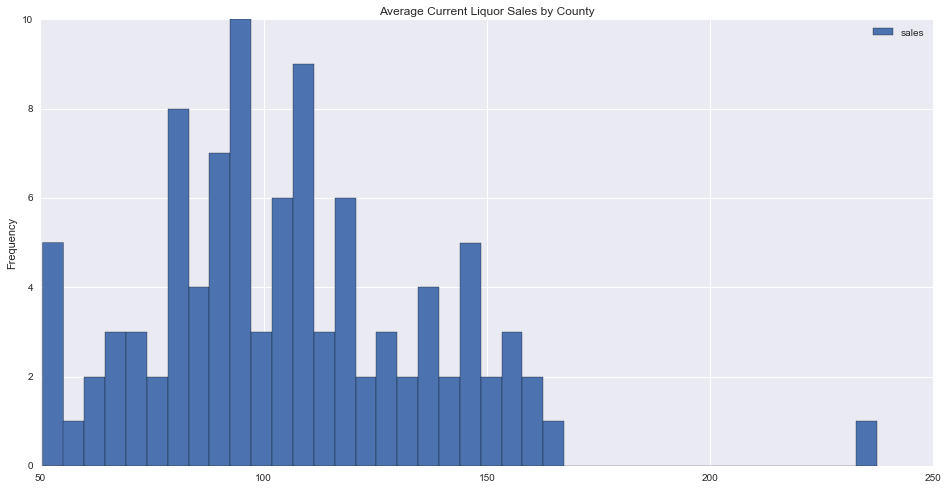

In [200]:
def my_pivot(df, index, values, aggfunc, plt=False):
    piv = pd.pivot_table(df, index=index, values=values, aggfunc=aggfunc)
    #piv.sort_values(by = ['week'], inplace=True)
    #print piv
    if plt: piv.plot(title= 'Average Current Liquor Sales by County',kind='hist', figsize=(16,8),bins=40)

my_pivot(idf, index=["county"], values=['sales'], aggfunc=np.mean, plt=True)

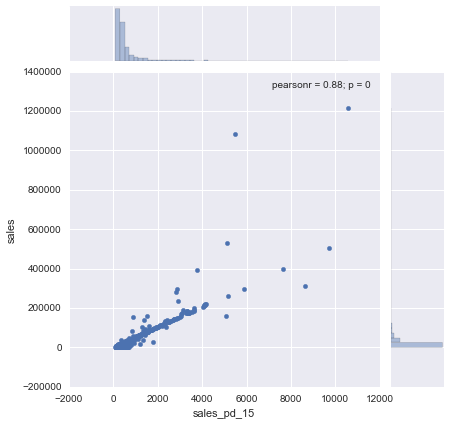

In [146]:
sns.jointplot(x=idf_new['sales_pd_15'], y=idf_new['sales'])

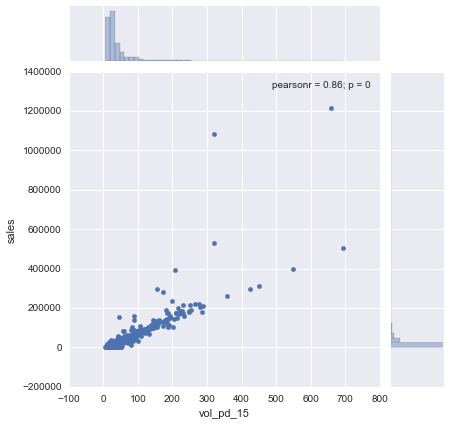

In [148]:
sns.jointplot(x=idf_new['vol_pd_15'], y=idf_new['sales'])

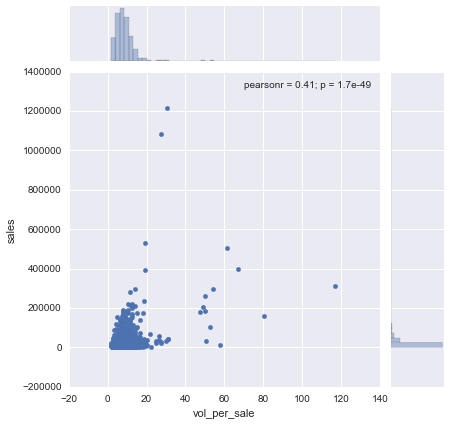

In [149]:
sns.jointplot(x=idf_new['vol_per_sale'], y=idf_new['sales'])

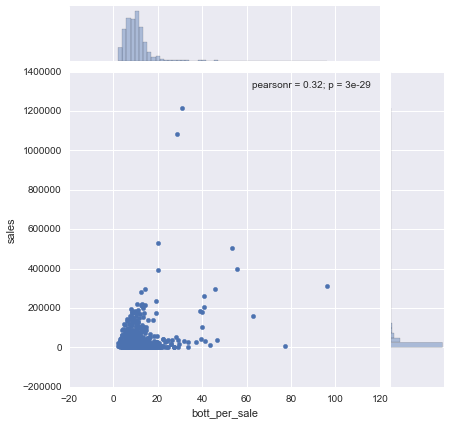

In [150]:
sns.jointplot(x=idf_new['bott_per_sale'], y=idf_new['sales'])

### Create new dataframe for Q1-2015 only

In [156]:
idf15 = iowa[iowa['store'].isin(open_stores)]
idf15 = idf[idf['quarter'] == 'Q1-2015']

In [164]:
idf15.head(5)

,date,store,city,zip_code,county,category_name,vendor_number,item_description,bottle_volume,state_bottle_cost,...,days_open_16,days_open,sales_pd_15,profit_pd_15,bottl_pd_15,vol_pd_15,sales_pd_16,profit_pd_16,bottles_pd_16,vol_pd_16
2,2015-01-21,3717,SUMNER,50674.0,Bremer,MISC. AMERICAN CORDIALS & LIQUEURS,322,Kinky Liqueur,750,10.00,...,13,63,0.6000,0.2000,0.04,0.030,2.307692,0.769231,0.153846,0.115385
4,2015-01-07,3717,SUMNER,50674.0,Bremer,STRAIGHT BOURBON WHISKIES,65,Maker's Mark,750,16.79,...,13,63,0.5038,0.1680,0.02,0.015,1.937692,0.646154,0.076923,0.057692
5,2015-02-18,3717,SUMNER,50674.0,Bremer,IRISH WHISKIES,370,Jameson Mini,600,11.88,...,13,63,0.3564,0.1188,0.02,0.012,1.370769,0.456923,0.076923,0.046154
10,2015-02-04,3717,SUMNER,50674.0,Bremer,CREAM LIQUEURS,305,Tippy Cow Chocolate Mini,500,7.42,...,13,63,0.2226,0.0742,0.02,0.010,0.856154,0.285385,0.076923,0.038462
20,2015-01-14,3717,SUMNER,50674.0,Bremer,IMPORTED SCHNAPPS,421,Dr. Mcgillicuddy's Cherry Schnapps,750,8.67,...,13,63,0.5204,0.1736,0.04,0.030,2.001538,0.667692,0.153846,0.115385


In [159]:
# 1: Create idf_sums
idf15_sums = idf15.groupby(['store'])[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(np.sum)
idf15_sums.reset_index(inplace=True)

# 2: Create idf_means
idf15_means = idf15.groupby(['store'])[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(np.mean)
idf15_means.reset_index(inplace=True)
idf15_means.columns = ['store', 'rev_per_sale', 'prof_per_sale', 'bott_per_sale', \
                    'vol_per_sale']

# 3: Merge sums and means into idf_sales
idf15_sales = idf15_sums.merge(idf15_means, how='inner', on='store')
idf15_sales.head(3)

,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale
0,2106,39287.29,13108.37,2705,2526.10,304.552636,101.615271,20.968992,19.582171
1,2113,2833.25,944.72,196,177.11,67.458333,22.493333,4.666667,4.216905
2,2130,24272.57,8108.68,1533,1447.25,278.995057,93.203218,17.620690,16.635057


In [170]:
# 4: Create new columns in idf for daily averages
days_open_Q1_15 = idf_open[idf_open['quarter'] == 'Q1-2015'].groupby(['store'])[['date']].agg(len)
days_open_Q1_15.reset_index(inplace=True)
days_open_Q1_15.columns = ['store', 'days_open_Q1_15']
days_open_Q1_15['days_open_Q1_15'] = days_open_Q1_15['days_open_Q1_15'].astype(int)

idf15['sales_pd_15'] = idf15['sales'] / days_open_Q1_15['days_open_Q1_15']
idf15['profit_pd_15'] = idf15['profit'] / days_open_Q1_15['days_open_Q1_15']
idf15['bottl_pd_15'] = idf15['bottles_sold'] / days_open_Q1_15['days_open_Q1_15']
idf15['vol_pd_15'] = idf15['volume_sold'] / days_open_Q1_15['days_open_Q1_15']

# 5: Separate daily average columns into own df
idf15_pd = idf.groupby(['store'])[['sales_pd_15', 'profit_pd_15', 'vol_pd_15']].agg(np.sum)
idf15_pd.reset_index(inplace=True)
idf15_pd.head(3)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

,store,sales_pd_15,profit_pd_15,vol_pd_15
0,2106,3394.566346,1133.016923,227.617308
1,2113,242.045106,80.904894,17.805319
2,2130,2681.538846,894.569423,162.235962


In [171]:
# 6: Merge sales and daily average dfs
idf15_metrics = idf15_sales.merge(idf15_pd, how='inner', on='store')
idf15_metrics.head(3)



,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale,sales_pd_15,profit_pd_15,vol_pd_15
0,2106,39287.29,13108.37,2705,2526.10,304.552636,101.615271,20.968992,19.582171,3394.566346,1133.016923,227.617308
1,2113,2833.25,944.72,196,177.11,67.458333,22.493333,4.666667,4.216905,242.045106,80.904894,17.805319
2,2130,24272.57,8108.68,1533,1447.25,278.995057,93.203218,17.620690,16.635057,2681.538846,894.569423,162.235962


In [172]:
# 7: Create location only df
idf_location = pd.pivot_table(idf, values=['sales'], index=['store', 'city', 'county', 'zip_code'], aggfunc=np.sum)
idf_location.reset_index(inplace=True)
idf_location.drop('sales', axis=1, inplace=True)
idf_location.head(3)

# 8: Create new df by merging metrics and location
idf15_new= idf15_metrics.merge(idf_location, how='inner', on='store')
idf15_new.head(3)

,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale,sales_pd_15,profit_pd_15,vol_pd_15,city,county,zip_code
0,2106,39287.29,13108.37,2705,2526.10,304.552636,101.615271,20.968992,19.582171,3394.566346,1133.016923,227.617308,CEDAR FALLS,Black Hawk,50613.0
1,2113,2833.25,944.72,196,177.11,67.458333,22.493333,4.666667,4.216905,242.045106,80.904894,17.805319,GOWRIE,Webster,50543.0
2,2130,24272.57,8108.68,1533,1447.25,278.995057,93.203218,17.620690,16.635057,2681.538846,894.569423,162.235962,WATERLOO,Black Hawk,50703.0


In [177]:
idf15_new['sales_2Q-4Q-15'] = idf_new['sales'] - idf15_new['sales']
idf15_new.head(3)

,store,sales,profit,bottles_sold,volume_sold,rev_per_sale,prof_per_sale,bott_per_sale,vol_per_sale,sales_pd_15,profit_pd_15,vol_pd_15,city,county,zip_code,sales_2Q-4Q-15
0,2106,39287.29,13108.37,2705,2526.10,304.552636,101.615271,20.968992,19.582171,3394.566346,1133.016923,227.617308,CEDAR FALLS,Black Hawk,50613.0,137230.16
1,2113,2833.25,944.72,196,177.11,67.458333,22.493333,4.666667,4.216905,242.045106,80.904894,17.805319,GOWRIE,Webster,50543.0,8542.87
2,2130,24272.57,8108.68,1533,1447.25,278.995057,93.203218,17.620690,16.635057,2681.538846,894.569423,162.235962,WATERLOO,Black Hawk,50703.0,115167.45


In [174]:
iowa_2015 = iowa[iowa['year'] == 2015]
iowa_2016 = iowa[iowa['year'] == 2016]

In [184]:
idf15_new['sales_2Q-4Q-15'].shape

(1183,)

In [187]:
# train all models only on data from stores with full data from 2015 (no stores which opened or closed)

# base model - predict 2015 Q2-4 with just 2015Q1
y = idf15_new['sales_2Q-4Q-15']
X  = idf15_new['sales']
X = pd.DataFrame(X)

lm = linear_model.LinearRegression()
base_model = lm.fit(X,y)

print "Coef:", base_model.coef_
print "Intercept:", base_model.intercept_
print "Score:", base_model.score(X, y) 
print "MSE:", mean_squared_error(y, base_model.predict(X))

Coef: [ 4.43774784]
Intercept: 961.70683133
Score: 0.947080335326
MSE: 155663845.944


In [188]:
print "Mean cross-val R2:",cross_val_score(lm, X, y, cv=5).mean()

Mean cross-val R2: 0.812246733482


In [194]:
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.33)
lm = linear_model.LinearRegression()
train_base_model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print "Train Test R2:", train_base_model.score(X_test, y_test) 

Train Test R2: 0.935974927712


### Full Year 2015

In [196]:
# train all models only on data from stores with full data from 2015 (no stores which opened or closed)

# base model - predict 2015 Q2-4 with just 2015Q1
y = iowa[[iowa['quarter']=='Q1-2015']]
X  = idf_new['sales']
X = pd.DataFrame(X)

lm = linear_model.LinearRegression()
base_model = lm.fit(X,y)

print "Coef:", base_model.coef_
print "Intercept:", base_model.intercept_
print "Score:", base_model.score(X, y) 
print "MSE:", mean_squared_error(y, base_model.predict(X))

ValueError: Item wrong length 1 instead of 270323.

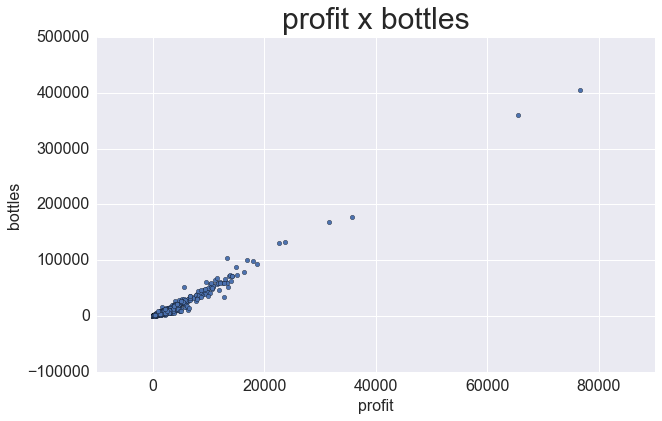

In [64]:
ax = idf_sales.plot(kind="scatter", x='bottles_sold', y='profit', figsize=(10,6))
ax.set_title('profit x bottles', y=1.01, fontsize=30)
ax.set_xlabel('profit', fontsize=16)
ax.set_ylabel('bottles', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=16)

### Dataframes by store

In [67]:
#Df showing full year sales by store 2015
print 'Nunique stores: ' + str(idf['store'].nunique())
idf_store_2015 = idf_2015.groupby(['store']) \
[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(sum)
idf_store_2015.reset_index(inplace=True)
idf_store_2015.head(3)

Nunique stores: 1183


,store,sales,profit,bottles_sold,volume_sold
0,2106,146038.70,48742.20,10355,9719.85
1,2113,9310.22,3109.04,671,659.85
2,2130,111583.91,37229.32,7418,6879.37


In [68]:
#Df showing full year sales by store 2016
print 'Nunique stores: ' + str(idf['store'].nunique())
idf_store_2016 = idf_2016.groupby(['store']) \
[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(sum)
idf_store_2016.reset_index(inplace=True)
idf_store_2016.head(3)

Nunique stores: 1183


,store,sales,profit,bottles_sold,volume_sold
0,2106,30478.75,10174.68,2218,2116.25
1,2113,2065.90,693.49,159,177.00
2,2130,27856.11,9288.29,1726,1556.90


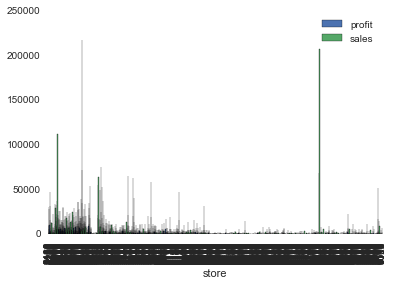

In [69]:
idf_store_2016.plot(x='store', y=['profit', 'sales'], kind= 'bar')

In [ ]:
#Df showing full year sales by county 2015
print 'Nunique counties: ' + str(idf['county'].nunique())
idf_county_2015 = idf_2015.groupby(['county']) \
[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(sum)
idf_county_2015.reset_index(inplace=True)
idf_county_2015.tail(3)

In [ ]:
#Df showing full year sales by city 2015
print 'Nunique cities: ' + str(idf['city'].nunique())
idf_city_2015 = idf_2015.groupby(['city']) \
[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(sum)
idf_city_2015.reset_index(inplace=True)
idf_city_2015.tail(3)

In [ ]:
#Df showing full year sales by zip 2015
print 'Nunique zip codes: ' + str(idf['zip_code'].nunique())
idf_zip_2015 = idf_2015.groupby(['zip_code']) \
[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(sum)
idf_zip_2015.reset_index(inplace=True)
idf_zip_2015.tail(3)

In [ ]:
#Df showing full year sales by category
print 'Nunique categories: ' + str(idf['category_name'].nunique())
idf_category_2015 = idf_2015.groupby(['category_name']) \
[['sales', 'profit', 'bottles_sold', 'volume_sold']].agg(sum)
idf_category_2015.reset_index(inplace=True)
idf_category_2015.tail(3)

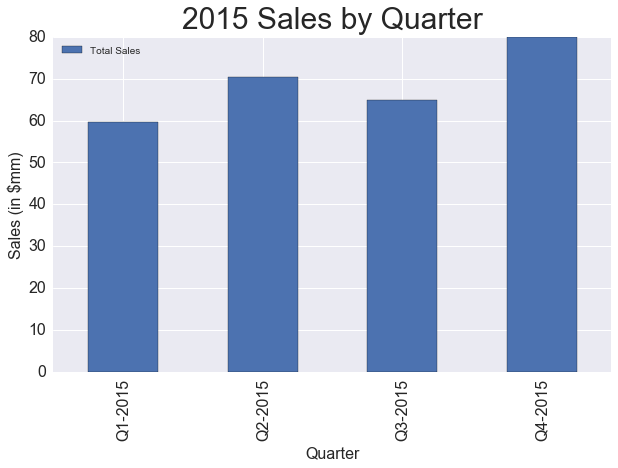

In [70]:
quarter_sales = idf[idf["year"]==2015].groupby(["quarter"])["sales"].agg([np.sum])
quarter_sales.columns = ["Total Sales"]
quarter_sales = quarter_sales.applymap(lambda x: x/100000)

ax = quarter_sales.plot(kind="bar", figsize=(10,6))
ax.set_title("2015 Sales by Quarter", y=1.01, fontsize=30)
ax.set_xlabel('Quarter', fontsize=16)
ax.set_ylabel('Sales (in $mm)', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=16)


In [ ]:
def my_pivot(df, index, values, aggfunc, plt=False):
    piv = pd.pivot_table(df, index=index, values=values, aggfunc=aggfunc)
    #piv.sort_values(by = ['week'], inplace=True)
    #print piv
    if plt: piv.plot(title= 'Average Current Liquor Sales by County',kind='hist', figsize=(16,8),bins=40)

my_pivot(idf, index=["store"], values=['sales'], aggfunc=np.mean, plt=True)

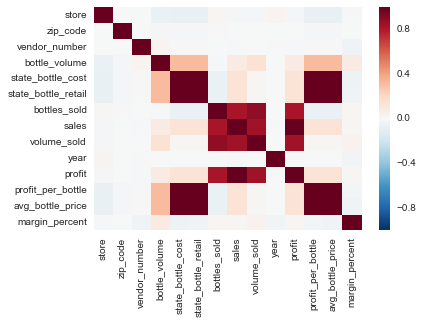

In [65]:
sns.heatmap(iowa.corr())

In [ ]:
iowa_target = pd.DataFrame(iowa['sales'])

In [ ]:
ax = sns.regplot(y_pred, y)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(14)

ax.set_ylabel('Actual Values')
ax.set_xlabel('Predicted Values')
ax.set_title('Predicted vs. Actual Values');

In [ ]:
lr_r2 =  r2_score(y_true=y, y_pred=y_pred)
lr_r2

In [ ]:
len(lr_model.coef_)

In [ ]:
lr_model.coef_

In [ ]:
iowa['bottle_volume'].unique()

In [ ]:
{'vodka': }
#vodka
#schnapps
#whiskey
#rum
#scotch
#gin
#liqueurs
#brandies
#tequila
#beer
#other


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
len(iowa['County'].value_counts())

In [ ]:
iowa_county = pd.pivot_table(iowa, index=iowa['County'], values=['Sale (Dollars)'])
iowa_county.head()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.